## Image Data Generator (Computer Vision)

## Initialization

In [1]:
#import libraries

#general 
import numpy as np
import pandas as pd

#machine learning needs 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#image specific
from IPython.display import display
from PIL import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt


## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. Build a generator with the ImageDataGenerator generator. 

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')


## EDA

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.shape

(7591, 2)

In [5]:
print('Duplicates:',labels.duplicated().sum())
print('NA:',labels.isna().sum())
print('Null',labels.isnull().sum())

Duplicates: 0
NA: file_name    0
real_age     0
dtype: int64
Null file_name    0
real_age     0
dtype: int64


In [6]:
#print example photos to explore
display(labels.tail(15))

,file_name,real_age
7576,007598.jpg,28
7577,007599.jpg,1
7578,007600.jpg,10
7579,007601.jpg,23
7580,007602.jpg,1
7581,007603.jpg,29
7582,007604.jpg,24
7583,007605.jpg,5
7584,007606.jpg,27
7585,007607.jpg,10


Text(0.5, 1.0, 'Distribution of Ages')

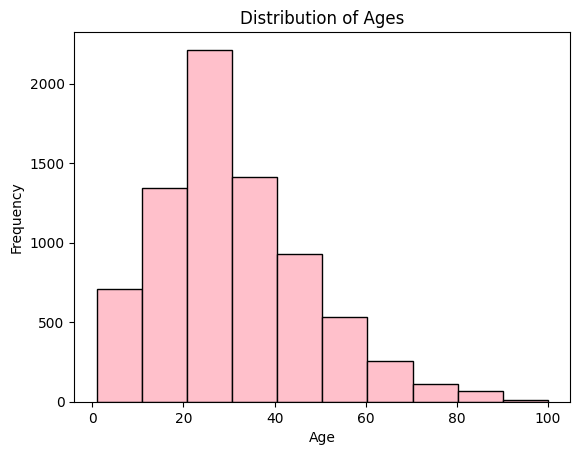

In [7]:
#show age distribution in dataset

# Create the histogram
plt.hist(labels['real_age'], bins=10, color='pink', edgecolor='black') 

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Ages')

In [8]:
sorted = labels.sort_values(by='real_age')
display(sorted)

,file_name,real_age
1005,001005.jpg,1
7313,007335.jpg,1
251,000251.jpg,1
7019,007030.jpg,1
3099,003099.jpg,1
...,...,...
6118,006121.jpg,95
6379,006383.jpg,96
6248,006252.jpg,96
5806,005806.jpg,97


In [9]:
#create brackets for each decade 
def age_bracket(age):
  """Categorizes age into brackets."""
  if age < 10:
    return "Children"
  elif 10 <= age <= 19:
    return "Teenagers"
  elif 20 <= age <= 29:
    return "Twenties"
  elif 30 <= age <= 39:
    return "Thirties"
  elif 40 <= age <= 49:
    return "Forties"
  elif 50 <= age <= 59:
    return "Fifties"
  elif 60 <= age <= 69:
    return "Sixties"
  elif 70 <= age <= 70:
    return "Seventies"
  elif 80 <= age <= 89:
    return "Eighties"
  else:
    return "Nineties"

# Apply the function to create a new 'Age Bracket' column
labels['age_bracket'] = labels['real_age'].apply(age_bracket)
age_range=labels['age_bracket'].value_counts()
print(age_range)

Twenties     2075
Thirties     1564
Teenagers    1213
Forties       940
Children      663
Fifties       615
Sixties       279
Nineties      114
Eighties       78
Seventies      50
Name: age_bracket, dtype: int64


Found 5694 validated image filenames.
Found 1897 validated image filenames.


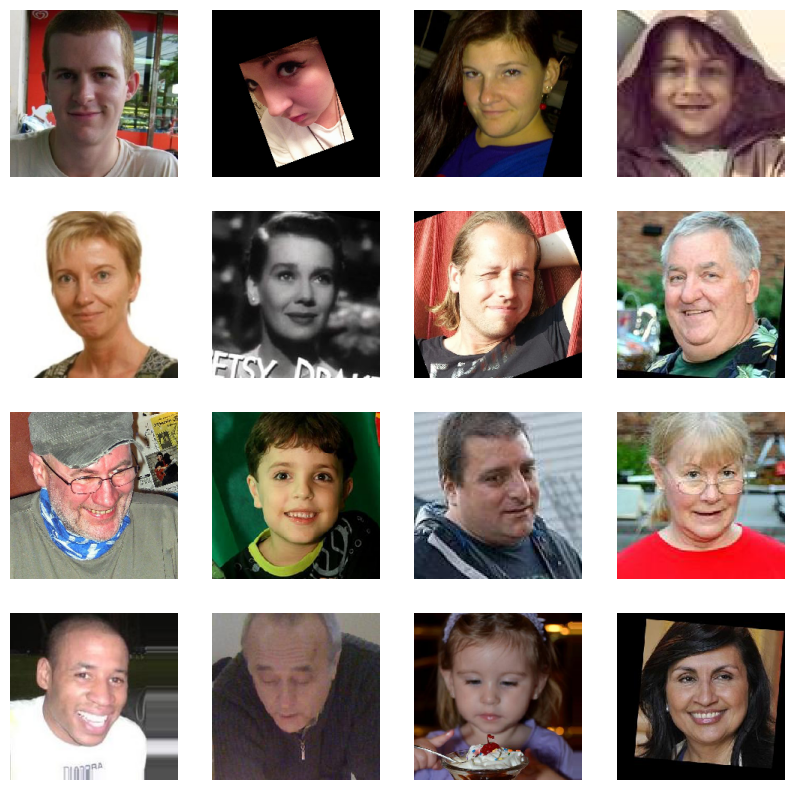

In [10]:
#print sample images to explore

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image data generator with rescaling
train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)

# Load training data
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
)

# Load validation data
val_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
)

# Fetch a batch of images and labels
features, target = next(train_gen_flow)

# Plot images
fig = plt.figure(figsize=(10,10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(features[i])  # Ensure features is an array
    ax.axis('off')

plt.show()


### Findings

Highest age bracket represented is from 20-30 years old.  The people in their seventies are least represented. In evaluating some sample images the photos are not unified in point of view of the camerea.  Some eyes are not visible, some photos have more of a side view, and varied lighting in each photo.  Plan to perform several augmentations to ensure the model is trained correctly.  

## Modelling

Define the necessary functions to train model on the GPU platform and build a single script containing all of them along with the initialization section.

In [11]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [12]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range=90)
    

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_gen_flow

In [13]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """    
    labels = pd.read_csv(path + 'labels.csv')
    #do not have any augmentations on test data image generation
    val_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    val_gen_flow = val_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return val_gen_flow

In [14]:
def create_model(input_shape):
    
    """
    It defines model
    """
    
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [15]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

In [16]:
load_train('/datasets/faces/')

Found 5694 validated image filenames.


In [17]:
load_test('/datasets/faces/')

Found 1897 validated image filenames.


In [18]:
model=create_model((224,224,3))
trained_model=train_model(model, train_data,test_data,batch_size=32, epochs=20,steps_per_epoch=178, validation_steps=60,)

2025-04-20 20:23:59.810679: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


94781440/94765736 [==============================] - 0s 0us/step


NameError: name 'train_data' is not defined

## Prepare the Script to Run on the GPU Platform

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

## Conclusions

The model shows  improvement in training performance over 20 epochs, with the training loss decreasing from 95.35 to 17.02.  Each epoch is a complete pass through training dataset.  Trailing loss measure how well the model's predictions match the actual values during training. The model is better at minimizing errors from the training set. 

Mean Absolute Error (MAE) calculates the average absolute difference between predicted and actual values which gives a metric of error in same units as target variable. MAE improved from 7.43 to 3.18. Lower MAE indicates that the predictions from the model are approaching the true values. 

The validation performance is inconsistent. Initially it decreases but it fluctuates and worsens in later epochs.  The peak was at 185.63 (epoch 12).  In final epoch was at 93.41. This gives evidence of overfitting. Regularization techniques or adjusting the learning rate may help improve generalization.